### Commit Classification and Prediction — Problem Description

Software repositories such as GitHub, Bitbucket, Gitlab etc. use commits to record changes in the source code, allowing teams of developers to collaborate effectively. Each commit includes a commit message, a brief summary describing the change. These messages generally shows whether the change involves fixing a bug, adding a feature, updating documentation, refactoring code, or making other non-functional improvements.

Automatically analyzing these commit messages is highly valuable because software projects frequently suffer from information overload, where developers spend significant time understanding the nature of past changes, which helps in identifying bug-prone commits, and prioritizing maintenance tasks. Prior research shows that commit categorization can accelerate issue resolution, enhance code review efficiency, and support project management workflows.

This project focuses on commit message classification, where the objective is to predict the macro-type of a software commit using only its natural-language commit message. We treat this as a supervised machine learning problem, leveraging a labeled dataset compiled from well-established and trusted sources. The dataset categorizes commits into five broad classes:

- Corrective — commits related to bug fixes or fault correction

- Feature — commits introducing new functionality or enhancements

- Non-Functional — documentation updates, formatting, or other structural changes that do not alter behavior

- Perfective — improvements to code quality, refactoring, or maintainability enhancements

- Unknown — commits that are auto-generated or whose purpose cannot be clearly determined

These categories provide a meaningful high-level taxonomy that supports automated analysis of software evolution and enables more efficient maintainability workflows.

To address this prediction task, we evaluate both traditional machine learning techniques (TF-IDF combined with Logistic Regression, Naive Bayes, and Random Forest) and a modern deep learning model (BERT). By applying natural language processing methods, our aim is to identify the most effective model for commit classification and to highlight how automated commit analysis can significantly aid software maintenance, quality assurance, and project analytics.

## Install the packages

In [1]:
!pip install -q transformers accelerate datasets sentencepiece

## Import the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
import os


from datasets import load_dataset, Dataset
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [3]:
# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

## Download English Stopwords
We download English stopwords because they are common words like the, is, and, of that usually do not carry meaningful information for text classification.

By removing stopwords during preprocessing, we:
- Reduce noise in the text,
- Focus the model on meaningful words, and
- Improve model performance and efficiency.

In [4]:
# Download the NLTK English stopwords list (common words to remove during text preprocessing)
nltk.download("stopwords")

# Load the English stopwords into a set for faster lookup during text cleaning
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Check device GPU or CPU
print("Torch device:", "cuda" if torch.cuda.is_available() else "cpu")

Torch device: cuda


## Load the dataset

In [6]:
dataset = load_dataset("0x404/ccs_dataset")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Convert each split to Pandas DataFrame
train_df = dataset["train"].to_pandas()
train_df

,commit_message,sha,type,annotated_type,masked_commit_message,git_diff,input_prompt
0,refactor(topology): coordinator accepts a requ...,dec860436916ef216998f80f8b2f9c39d00c064d,refactor,feat,coordinator accepts a request transformer inst...,diff --git a/topology/src/main/java/io/camunda...,
1,style(content): remove unused,a50b51999015e210918d9c8e95fd4cac347353be,style,refactor,remove unused,diff --git a/src/content/redux/modules/diction...,
2,feat: add dirty checker,d1f849e5d0813d27bcc4f99164796622d81d31cd,feat,feat,add dirty checker,diff --git a/packages/compiler/experimental/ut...,
3,style: dis-`allow()` untriggered lints,816b0d49c45f6669c5aae748396e9551f2e30a96,style,style,dis-`allow()` untriggered lints,diff --git a/src/app/help.rs b/src/app/help.rs...,
4,fix(alert): disable listeners until ready\n\nC...,584470337a0ee82bfa92e43fac291bb8e5132fa0,fix,fix,disable listeners until ready\n\nCloses #5821,diff --git a/ionic/components/action-sheet/act...,
...,...,...,...,...,...,...,...
1395,style: update tracing docker-compose definition,5257f73d44f8532816f536694d53405bf6eaad9b,style,style,update tracing docker-compose definition,diff --git a/quickstart-tracing.yml b/quicksta...,
1396,refactor(broker): log write failure for more c...,3ca1a12dce72a6c6c85ff12d228d3b0ad11452a5,refactor,refactor,log write failure for more context,diff --git a/broker/src/main/java/io/camunda/z...,
1397,fix(pkg/csv2lp): don't allow duplicate tags #1...,238ba1990ea68eb64bdfc6b31efebad2acb01ad6,fix,fix,don't allow duplicate tags #19453,diff --git a/pkg/csv2lp/csv_table.go b/pkg/csv...,
1398,fix: verify property exist in row object\n\nSi...,c6403b62f8dc0e5bfe25a1c6306fb7040ca447ae,fix,fix,verify property exist in row object\n\nSigned-...,diff --git a/packages/nc-gui/components/smarts...,


In [8]:
train_df.columns

Index(['commit_message', 'sha', 'type', 'annotated_type',
       'masked_commit_message', 'git_diff', 'input_prompt'],
      dtype='object')

In [9]:
val_df   = dataset["eval"].to_pandas()
val_df

,commit_message,sha,type,annotated_type,masked_commit_message,git_diff,input_prompt
0,test(qa): verify resolve incident command\n\nV...,f5488b00c797edd1de941aa0fa8b8352408bb9c3,test,test,verify resolve incident command\n\nVerifies th...,diff --git a/qa/integration-tests/src/test/jav...,<s>[INST] <<SYS>>\nYou are a commit classifier...
1,feat(clients/go): add resolve incident command,e1a850db1fe5023f1669a3555c2a0e7ff3cf6064,feat,feat,add resolve incident command,diff --git a/clients/go/commands/resolveIncide...,<s>[INST] <<SYS>>\nYou are a commit classifier...
2,perf(core): cache if entity has event listeners,cfa8d52fa0c3e783ae7842ef7932cc1f73663942,perf,perf,cache if entity has event listeners,diff --git a/packages/core/src/enums.ts b/pack...,<s>[INST] <<SYS>>\nYou are a commit classifier...
3,docs: fix docker.md parsing error,4b0735f5b64da0c7d6aba1a15d803d1767048fe4,docs,docs,fix docker.md parsing error,diff --git a/docs/setup/installation/platforms...,<s>[INST] <<SYS>>\nYou are a commit classifier...
4,feat: add --enable-api-filtering-logging comma...,ccff140046336275dd8898f694bd2e6b3141401d,feat,feat,add --enable-api-filtering-logging commandline...,diff --git a/docs/README.md b/docs/README.md\n...,<s>[INST] <<SYS>>\nYou are a commit classifier...
...,...,...,...,...,...,...,...
195,fix(config): print error correctly in eval,f0c5ace9b5c5b7ea55da8607524d6cb68c615455,fix,fix,print error correctly in eval,diff --git a/src/engine/config.go b/src/engine...,<s>[INST] <<SYS>>\nYou are a commit classifier...
196,feat: Make configuration loading synchronous w...,5c88e24bfb0815df8a323ff0e076b5332bdde5b1,feat,feat,Make configuration loading synchronous with as...,diff --git a/packages/@css-blocks/config/src/i...,<s>[INST] <<SYS>>\nYou are a commit classifier...
197,ci: deploy docker image snapshots\n\nDeploy do...,afeef6fe8d1d4c9decb23e2ee9ab6f527635b62c,ci,ci,deploy docker image snapshots\n\nDeploy docker...,diff --git a/.github/workflows/deploy.yml b/.g...,<s>[INST] <<SYS>>\nYou are a commit classifier...
198,perf(pandas): remove reexecution of alias chil...,64efa5376b9b96e23666242dad618512d886a124,perf,perf,remove reexecution of alias children,diff --git a/ibis/backends/pandas/execution/ge...,<s>[INST] <<SYS>>\nYou are a commit classifier...


In [10]:
test_df  = dataset["test"].to_pandas()
test_df

,commit_message,sha,type,annotated_type,masked_commit_message,git_diff,input_prompt
0,perf: Do not clone subcommands\n\nThis saves a...,7774a8ee8a653415b81d3ed794db9f15a3367016,perf,perf,Do not clone subcommands\n\nThis saves a whopp...,diff --git a/src/output/help.rs b/src/output/h...,<s>[INST] <<SYS>>\nYou are a commit classifier...
1,ci: pr add label,f4e050abe0404b91c1364ff7f78cfdfc25e6c08c,ci,ci,pr add label,diff --git a/.github/workflows/pr-branch.yml b...,<s>[INST] <<SYS>>\nYou are a commit classifier...
2,ci: move conda-lock regeneration to nightly PR...,9409af5c5bc85fd2838f80af536152cf32ec94bb,ci,ci,move conda-lock regeneration to nightly PR cre...,diff --git a/.github/workflows/conda-lock-pr.y...,<s>[INST] <<SYS>>\nYou are a commit classifier...
3,chore: add package lock,e52bbd2f2d5b59bc0d27a4524e9dddb344c0f154,chore,chore,add package lock,diff --git a/packages/engine-server/package-lo...,<s>[INST] <<SYS>>\nYou are a commit classifier...
4,refactor(broker): introduce helper class to us...,ea75d16c7309ff6b3fb58de22240d9c96fbbaf97,refactor,feat,introduce helper class to use new steps in old...,diff --git a/broker/src/main/java/io/camunda/z...,<s>[INST] <<SYS>>\nYou are a commit classifier...
...,...,...,...,...,...,...,...
395,refactor: wire up read_aggregate in table,eaabb82404502c622e8a5a6ce7607165f76f2086,refactor,refactor,wire up read_aggregate in table,diff --git a/read_buffer/src/chunk.rs b/read_b...,<s>[INST] <<SYS>>\nYou are a commit classifier...
396,perf: prevent re-renders if state didn't change,a6d5eb011843870ab58d42613e07d1165d7cf3cc,perf,perf,prevent re-renders if state didn't change,diff --git a/src/NavigationContainer.tsx b/src...,<s>[INST] <<SYS>>\nYou are a commit classifier...
397,fix: Update s3 error function to correct pattern,625542c31043573c74271c28bcfdc504cc5f636b,fix,fix,Update s3 error function to correct pattern,diff --git a/object_store/src/lib.rs b/object_...,<s>[INST] <<SYS>>\nYou are a commit classifier...
398,test(engine): reproduce class cast exception\n...,890cf79123fb7b8c228f5db4b8ad6ab6b4976d5f,test,test,reproduce class cast exception\n\nUsing the ex...,diff --git a/engine/src/test/java/io/camunda/z...,<s>[INST] <<SYS>>\nYou are a commit classifier...


In [11]:
print("\nDATASET SIZES:")
for split in dataset.keys():
    print(f"{split}: {len(dataset[split])} samples")


DATASET SIZES:
train: 1400 samples
test: 400 samples
eval: 200 samples


In [12]:
# Convert to Pandas DataFrames and rename columns
train_df_raw = dataset["train"].to_pandas()[["masked_commit_message", "annotated_type"]]
val_df_raw   = dataset["eval"].to_pandas()[["masked_commit_message", "annotated_type"]]
test_df_raw  = dataset["test"].to_pandas()[["masked_commit_message", "annotated_type"]]

train_df_raw = train_df_raw.rename(columns={"masked_commit_message": "Message", "annotated_type": "Ground truth"})
val_df_raw   = val_df_raw.rename(columns={"masked_commit_message": "Message", "annotated_type": "Ground truth"})
test_df_raw  = test_df_raw.rename(columns={"masked_commit_message": "Message", "annotated_type": "Ground truth"})

In [13]:
print("\n Raw training data (First 5 rows)")
train_df_raw.head()


 Raw training data (First 5 rows)


,Message,Ground truth
0,coordinator accepts a request transformer inst...,feat
1,remove unused,refactor
2,add dirty checker,feat
3,dis-`allow()` untriggered lints,style
4,disable listeners until ready\n\nCloses #5821,fix


## Clean an dPreprocess Commit Messages


This function cleans commit messages by converting to lowercase, removing URLs,
keeping only alphabetic characters, removing extra spaces, and filtering out stopwords.


In [14]:
def preprocess(df):
    """
    Clean commit messages:
    - Convert to lowercase
    - Remove URLs
    - Keep only alphabetic characters
    - Remove stopwords
    """
    df = df.copy()
    df["Message"] = df["Message"].astype(str)

    def clean(t):
        t = t.lower()
        t = re.sub(r"http\S+", "", t)          # Remove URLs
        t = re.sub(r"[^a-z\s]", " ", t)       # Remove non-alphabetic characters
        t = re.sub(r"\s+", " ", t).strip()    # Remove extra spaces
        return " ".join([w for w in t.split() if w not in stop_words])

    df["clean_message"] = df["Message"].apply(clean)
    return df

In [15]:
train_df = preprocess(train_df_raw)
val_df   = preprocess(val_df_raw)
test_df  = preprocess(test_df_raw)

In [16]:
print("\n Cleaned Training Data (First 5 rows)")

train_df.head()


 Cleaned Training Data (First 5 rows)


,Message,Ground truth,clean_message
0,coordinator accepts a request transformer inst...,feat,coordinator accepts request transformer instea...
1,remove unused,refactor,remove unused
2,add dirty checker,feat,add dirty checker
3,dis-`allow()` untriggered lints,style,dis allow untriggered lints
4,disable listeners until ready\n\nCloses #5821,fix,disable listeners ready closes


## Explorartory Data Analysis

## Label Distribution Plot
Shows how frequently each ground-truth label appears in the training set, helping identify class imbalance.

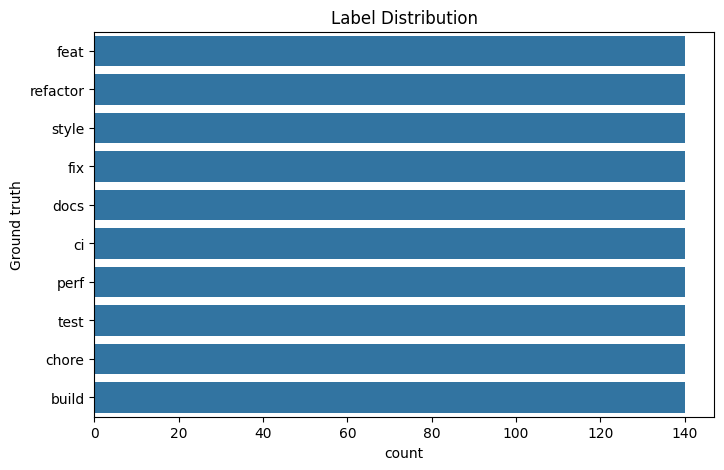

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(y=train_df["Ground truth"], order=train_df["Ground truth"].value_counts().index)
plt.title("Label Distribution")
plt.show()

In [18]:
train_df["msg_len"] = train_df["clean_message"].apply(lambda x: len(x.split()))
train_df

,Message,Ground truth,clean_message,msg_len
0,coordinator accepts a request transformer inst...,feat,coordinator accepts request transformer instea...,41
1,remove unused,refactor,remove unused,2
2,add dirty checker,feat,add dirty checker,3
3,dis-`allow()` untriggered lints,style,dis allow untriggered lints,4
4,disable listeners until ready\n\nCloses #5821,fix,disable listeners ready closes,4
...,...,...,...,...
1395,update tracing docker-compose definition,style,update tracing docker compose definition,5
1396,log write failure for more context,refactor,log write failure context,4
1397,don't allow duplicate tags #19453,fix,allow duplicate tags,3
1398,verify property exist in row object\n\nSigned-...,fix,verify property exist row object signed pranav...,11


### Message Length Distribution
Displays how long commit messages typically are, revealing patterns such as very short or very long messages

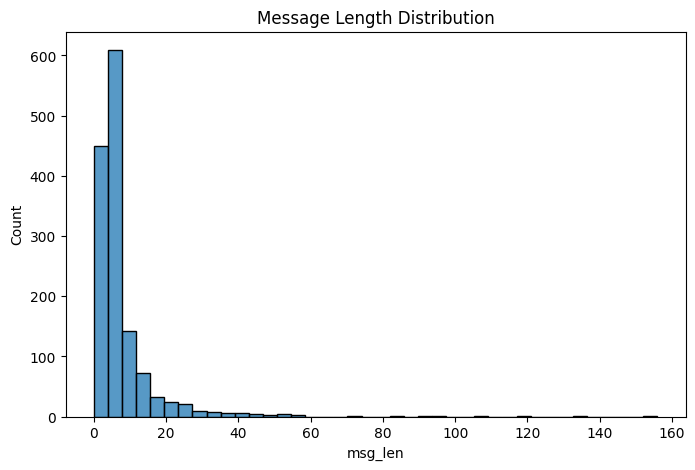

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(train_df["msg_len"], bins=40)
plt.title("Message Length Distribution")
plt.show()

## 5. TF-IDF Feature Extraction
Converts text into numerical vectors by measuring how important each word is within a message relative to the entire dataset. This helps machine-learning models understand and compare commit messages based on their content.



In [20]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_message"])
X_val   = vectorizer.transform(val_df["clean_message"])
X_test  = vectorizer.transform(test_df["clean_message"])

y_train = train_df["Ground truth"]
y_val   = val_df["Ground truth"]
y_test  = test_df["Ground truth"]

## Train Classical Machine Learning Models

## Logistic Regression Model
A linear classification model that learns weighted features to predict labels; class_weight="balanced" helps handle class imbalance.

In [21]:
# Logistic Regression
log = LogisticRegression(max_iter=2000, class_weight="balanced")
log.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000)

## Naive Bayes Model
A probabilistic classifier based on word-frequency statistics, assuming features are conditionally independent—fast and effective for text.

In [22]:
# Naive bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

## Random Forest
An ensemble of many decision trees that vote on the final prediction, improving accuracy and reducing overfitting.

In [23]:
# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

/tmp/ipython-input-2271775715.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="magma")


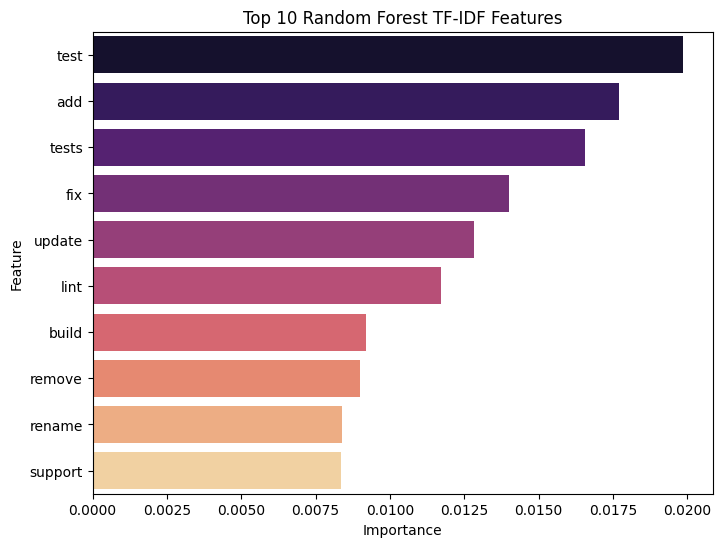

In [24]:
# Get feature importances from Random Forest
importances = rf.feature_importances_

# Get feature names from TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get indices of top 15 important features
indices = np.argsort(importances)[-10:][::-1]

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="magma")
plt.title("Top 10 Random Forest TF-IDF Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Evaluation Of TF-IDF(Term Frequency–Inverse Document Frequency) Models
Each trained model is evaluated using accuracy and macro-F1 scores on the training, validation, and test sets. This helps compare how well the models learn from the data, generalize to unseen data, and handle class imbalance. The resulting table summarizes the performance of Logistic Regression, Naive Bayes, and Random Forest side-by-side.

In [25]:
def evaluate_model(name, model, X_train, X_val, X_test, y_train, y_val, y_test):
    return {
        "Model": name,
        "Train Acc": accuracy_score(y_train, model.predict(X_train)),
        "Val Acc": accuracy_score(y_val, model.predict(X_val)),
        "Test Acc": accuracy_score(y_test, model.predict(X_test)),
        "Train F1": f1_score(y_train, model.predict(X_train), average="macro"),
        "Val F1": f1_score(y_val, model.predict(X_val), average="macro"),
        "Test F1": f1_score(y_test, model.predict(X_test), average="macro"),
    }

In [26]:
results_detailed = [
    evaluate_model("Logistic Regression", log, X_train, X_val, X_test, y_train, y_val, y_test),
    evaluate_model("Naive Bayes", nb, X_train, X_val, X_test, y_train, y_val, y_test),
    evaluate_model("Random Forest", rf, X_train, X_val, X_test, y_train, y_val, y_test),
]

df_compare = pd.DataFrame(results_detailed)
print("\n Training / Validation / Test data performance results (TF-IDF Models) ")
df_compare


 Training / Validation / Test data performance results (TF-IDF Models) 


,Model,Train Acc,Val Acc,Test Acc,Train F1,Val F1,Test F1
0,Logistic Regression,0.913571,0.580,0.585,0.913013,0.581173,0.582608
1,Naive Bayes,0.938571,0.575,0.600,0.938398,0.568358,0.589059
2,Random Forest,0.997143,0.525,0.490,0.997145,0.529847,0.490515


In [27]:
labels = sorted(train_df["Ground truth"].unique())

### Confusion Matrix
A confusion matrix is used to visualize how well a classification model performs by showing the counts of correct and incorrect predictions for each class.
It helps identify which classes the model predicts accurately and where it makes mistakes.

In [28]:
def plot_confusion_matrix(y_true, y_pred, title, cmap):
    plt.figure(figsize=(10,7))
    sns.heatmap(
        confusion_matrix(y_true, y_pred, labels=labels),
        annot=True,
        cmap=cmap,
        fmt="d",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.show()

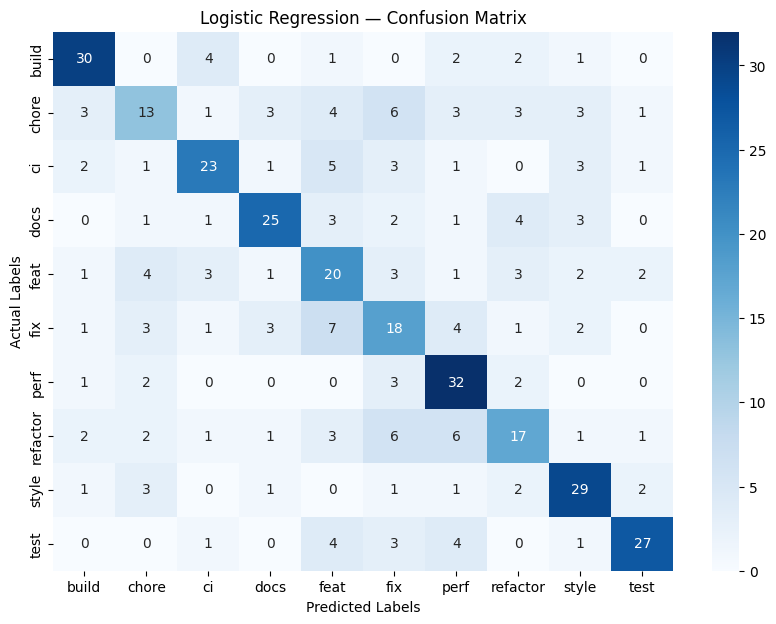

In [29]:
plot_confusion_matrix(y_test, log.predict(X_test), "Logistic Regression — Confusion Matrix", "Blues")

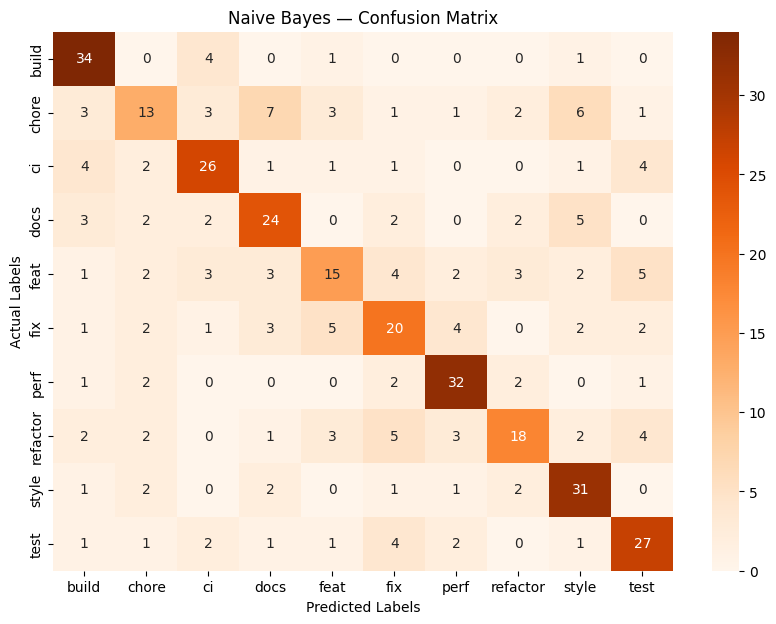

In [30]:
plot_confusion_matrix(y_test, nb.predict(X_test),  "Naive Bayes — Confusion Matrix", "Oranges")

The Naive Bayes model is performing well overall, with strong correct predictions for classes like build, ci, docs, perf, style, and test, but it notably confuses semantically similar categories such as feat, fix, refactor

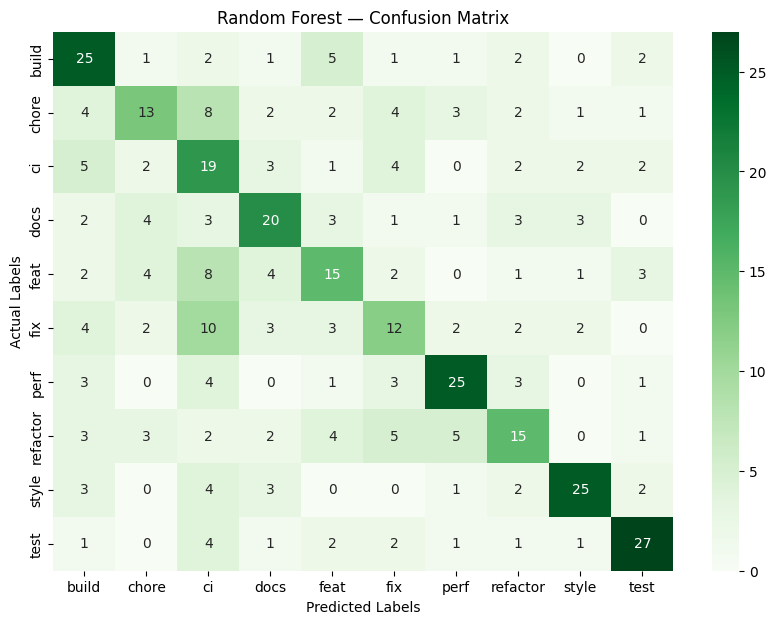

In [31]:
plot_confusion_matrix(y_test, rf.predict(X_test),  "Random Forest — Confusion Matrix", "Greens")

## Prepare data for BERT(Bidirectional Encoder Representations from Transformers)
It is a powerful pre-trained language model developed by Google that understands text by looking at words in both directions (left and right), making it highly effective for NLP tasks like classification, sentiment analysis, and question answering. BERT can deeply understand the meaning, context, and intent behind commit messages. This helps classify commits more accurately (e.g., bug fix, feature, refactor) because BERT captures nuances such as technical terms, action verbs, and contextual relationships that simpler models (TF-IDF + ML) may miss.

Implementation Explanation: This code prepares commit messages for BERT-based classification. It converts textual labels to numeric IDs, formats the data as HuggingFace Dataset objects, tokenizes the messages into BERT-compatible input IDs and attention masks, removes the original text, and sets the datasets to PyTorch format for model training. This ensures the data is ready for fine-tuning a BERT model.

In [32]:
label_list = labels
label_list

['build',
 'chore',
 'ci',
 'docs',
 'feat',
 'fix',
 'perf',
 'refactor',
 'style',
 'test']

In [33]:
# Create label-to-ID and ID-to-label mappings

label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}
id2label

{0: 'build',
 1: 'chore',
 2: 'ci',
 3: 'docs',
 4: 'feat',
 5: 'fix',
 6: 'perf',
 7: 'refactor',
 8: 'style',
 9: 'test'}

In [34]:
# Convert original dataframe into a format suitable for BERT

def make_bert_df(df):
    x = df[["clean_message", "Ground truth"]].copy()
    x = x.rename(columns={"clean_message": "text", "Ground truth": "label"})
    x["label"] = x["label"].map(label2id)
    return x

In [35]:
# Convert DataFrames to HuggingFace Dataset objects

train_bert = Dataset.from_pandas(make_bert_df(train_df))
val_bert   = Dataset.from_pandas(make_bert_df(val_df))
test_bert  = Dataset.from_pandas(make_bert_df(test_df))

In [36]:
# Load BERT tokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [37]:
# Tokenization function to convert text → BERT input IDs & attention masks

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,            # Cut text longer than max_length
        padding="max_length",       # Pad all sequences to a fixed length
        max_length=128              # Maximum token length
        )

In [38]:
# Tokenize datasets and remove raw text column (BERT uses tokenized inputs instead)

train_tok = train_bert.map(tokenize, batched=True).remove_columns(["text"])
val_tok   = val_bert.map(tokenize, batched=True).remove_columns(["text"])
test_tok  = test_bert.map(tokenize, batched=True).remove_columns(["text"])

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [39]:
# Convert tokenized datasets into PyTorch format for training

train_tok.set_format("torch")
val_tok.set_format("torch")
test_tok.set_format("torch")

## BERT Model Training

In [40]:
# Load pre-trained BERT model for sequence classification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Define training hyperparameters and settings
args = TrainingArguments(
    output_dir="bert_ccs",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

In [42]:
# Define evaluation metrics function

def metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1_macro": f1_score(p.label_ids, preds, average="macro")
    }

In [43]:
# Initialize the Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    compute_metrics=metrics,
)

/tmp/ipython-input-1551353619.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [44]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,2.115757,0.255000,0.219376
2,No log,1.844980,0.400000,0.370436
3,No log,1.699897,0.470000,0.444977
4,No log,1.590410,0.485000,0.462929
5,No log,1.520646,0.520000,0.507984
6,1.613600,1.493953,0.490000,0.489731
7,1.613600,1.459188,0.555000,0.552902
8,1.613600,1.479966,0.545000,0.540206
9,1.613600,1.482683,0.545000,0.544699
10,1.613600,1.474533,0.565000,0.562581


TrainOutput(global_step=880, training_loss=1.2004351702603426, metrics={'train_runtime': 274.2241, 'train_samples_per_second': 51.053, 'train_steps_per_second': 3.209, 'total_flos': 920954840064000.0, 'train_loss': 1.2004351702603426, 'epoch': 10.0})

The BERT model achieved a Test Accuracy of 57.5% and F1-score of 56.5%, demonstrating its capability to capture semantic patterns in commit messages. Its main difficulty was distinguishing commit types with overlapping meanings, such as 'feature addition' vs. 'code refactoring

In [45]:
metrics_history = trainer.state.log_history
metrics_history

[{'eval_loss': 2.1157567501068115,
  'eval_accuracy': 0.255,
  'eval_f1_macro': 0.21937601600343398,
  'eval_runtime': 0.7736,
  'eval_samples_per_second': 258.538,
  'eval_steps_per_second': 9.049,
  'epoch': 1.0,
  'step': 88},
 {'eval_loss': 1.8449804782867432,
  'eval_accuracy': 0.4,
  'eval_f1_macro': 0.37043648470198676,
  'eval_runtime': 0.4229,
  'eval_samples_per_second': 472.923,
  'eval_steps_per_second': 16.552,
  'epoch': 2.0,
  'step': 176},
 {'eval_loss': 1.6998974084854126,
  'eval_accuracy': 0.47,
  'eval_f1_macro': 0.44497729662435537,
  'eval_runtime': 0.339,
  'eval_samples_per_second': 589.929,
  'eval_steps_per_second': 20.648,
  'epoch': 3.0,
  'step': 264},
 {'eval_loss': 1.590409517288208,
  'eval_accuracy': 0.485,
  'eval_f1_macro': 0.4629292103245592,
  'eval_runtime': 0.3576,
  'eval_samples_per_second': 559.238,
  'eval_steps_per_second': 19.573,
  'epoch': 4.0,
  'step': 352},
 {'eval_loss': 1.5206457376480103,
  'eval_accuracy': 0.52,
  'eval_f1_macro': 0

## Training / Validation Metrics Over Epochs

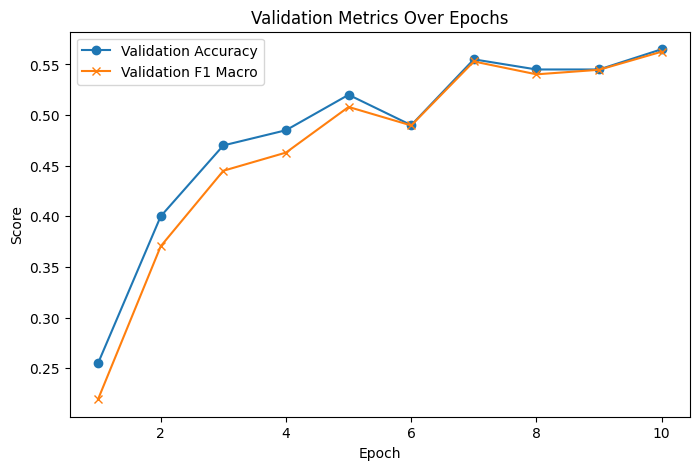

In [46]:
# Only keep entries with evaluation metrics
eval_metrics = [m for m in metrics_history if "eval_accuracy" in m]

epochs = [m["epoch"] for m in eval_metrics]
val_acc = [m["eval_accuracy"] for m in eval_metrics]
val_f1 = [m["eval_f1_macro"] for m in eval_metrics]

# Plot
plt.figure(figsize=(8,5))
plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
plt.plot(epochs, val_f1, label="Validation F1 Macro", marker='x')
plt.title("Validation Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

## Label Distribution Visualization

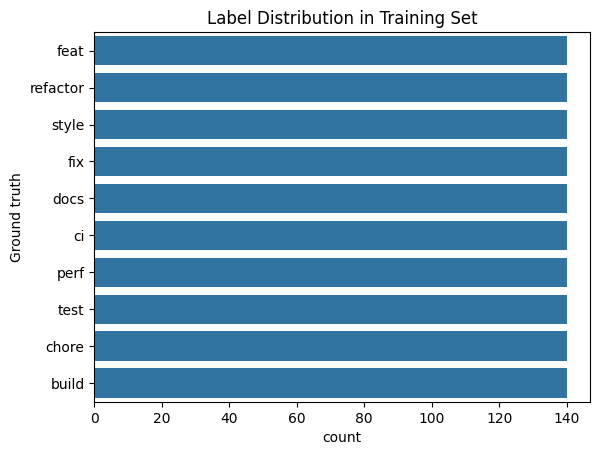

In [47]:
sns.countplot(y=train_df["Ground truth"], order=train_df["Ground truth"].value_counts().index)
plt.title("Label Distribution in Training Set")
plt.show()

## Prediction Distribution

In [48]:
bert_preds = trainer.predict(test_tok)
bert_pred = np.argmax(bert_preds.predictions, axis=1)
bert_true = bert_preds.label_ids

print("\nBERT Classification Report:\n",
      classification_report(bert_true, bert_pred, target_names=label_list))


BERT Classification Report:
               precision    recall  f1-score   support

       build       0.68      0.65      0.67        40
       chore       0.42      0.33      0.37        40
          ci       0.44      0.53      0.48        40
        docs       0.59      0.57      0.58        40
        feat       0.57      0.53      0.55        40
         fix       0.33      0.47      0.39        40
        perf       0.70      0.57      0.63        40
    refactor       0.41      0.40      0.41        40
       style       0.65      0.70      0.67        40
        test       0.77      0.68      0.72        40

    accuracy                           0.54       400
   macro avg       0.56      0.54      0.55       400
weighted avg       0.56      0.54      0.55       400



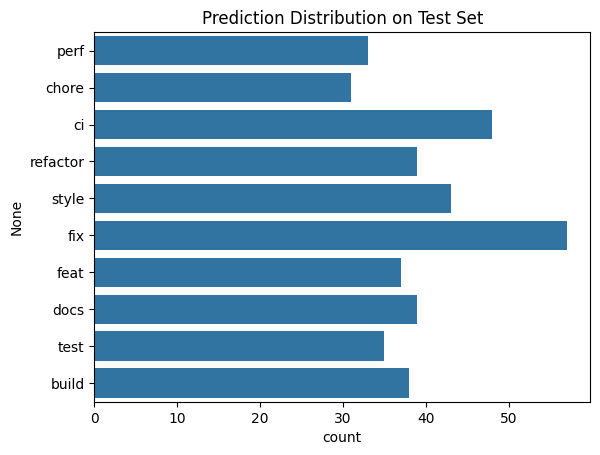

In [49]:
sns.countplot(y=pd.Series(bert_pred).map(lambda x: id2label[x]))
plt.title("Prediction Distribution on Test Set")
plt.show()

## BERT Testing Evaluation

## Sample Misclassifications
As To understand errors, you can show a few commit messages that were misclassified:

In [50]:
misclassified = test_df.copy()
misclassified['pred'] = bert_pred
misclassified = misclassified[misclassified['pred'] != misclassified['Ground truth'].map(label2id)]
misclassified[['Message', 'Ground truth', 'pred']].head(10)

,Message,Ground truth,pred
1,pr add label,ci,1
3,add package lock,chore,2
4,introduce helper class to use new steps in old...,feat,7
5,aot (wrong reference),fix,8
8,add examples for custom color w/ attribute,test,3
10,Adjust path to deploy_key (#130),chore,2
11,allow changing priority of a raft replica dyna...,feat,5
12,replace XComponent props in favor of render ca...,refactor,6
18,show stack trace in the flipper plugin,feat,3
19,fix branch name,ci,0


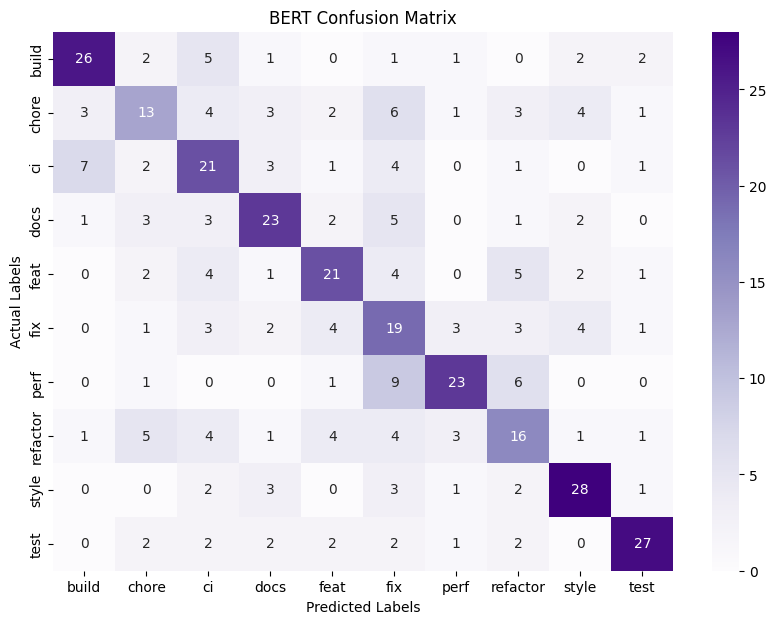

In [51]:
# Confusion matrix
cm_bert = confusion_matrix(bert_true, bert_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm_bert, annot=True, cmap="Purples",
            xticklabels=label_list, yticklabels=label_list)
plt.title("BERT Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

In [52]:
# Normalized Confusion Matrix
def plot_normalized_confusion_matrix(y_true, y_pred, title):
    labels = np.arange(len(label_list))  # numeric labels 0 to 9
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Purples",
                xticklabels=label_list, yticklabels=label_list)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [ ]:
plot_normalized_confusion_matrix(bert_true, bert_pred, "BERT Normalized Confusion Matrix")

## BERT Training / Validation / Test performance


In [53]:
train_out = trainer.predict(train_tok)
bert_train_pred = np.argmax(train_out.predictions, axis=1)
bert_train_true = train_out.label_ids

val_out = trainer.predict(val_tok)
bert_val_pred = np.argmax(val_out.predictions, axis=1)
bert_val_true = val_out.label_ids

bert_results = {
    "Model": "BERT",
    "Train Acc": accuracy_score(bert_train_true, bert_train_pred),
    "Val Acc": accuracy_score(bert_val_true, bert_val_pred),
    "Test Acc": accuracy_score(bert_true, bert_pred),
    "Train F1": f1_score(bert_train_true, bert_train_pred, average="macro"),
    "Val F1": f1_score(bert_val_true, bert_val_pred, average="macro"),
    "Test F1": f1_score(bert_true, bert_pred, average="macro"),
}

print("\n=== BERT TRAIN / VAL / TEST PERFORMANCE ===")
print(pd.DataFrame([bert_results]))


=== BERT TRAIN / VAL / TEST PERFORMANCE ===
  Model  Train Acc  Val Acc  Test Acc  Train F1    Val F1   Test F1
0  BERT   0.901429    0.555    0.5425  0.898282  0.552902  0.545952


## Observations
Overall, TF‑IDF + Logistic Regression gives the best balance of performance, simplicity, and interpretability on your commit-message task, and the notebook would benefit most from making label mappings explicit, emphasizing macro‑F1 and per-class metrics, and adding a concise, side‑by‑side comparison and brief error analysis (especially versus BERT) to clearly show where each model helps or struggles